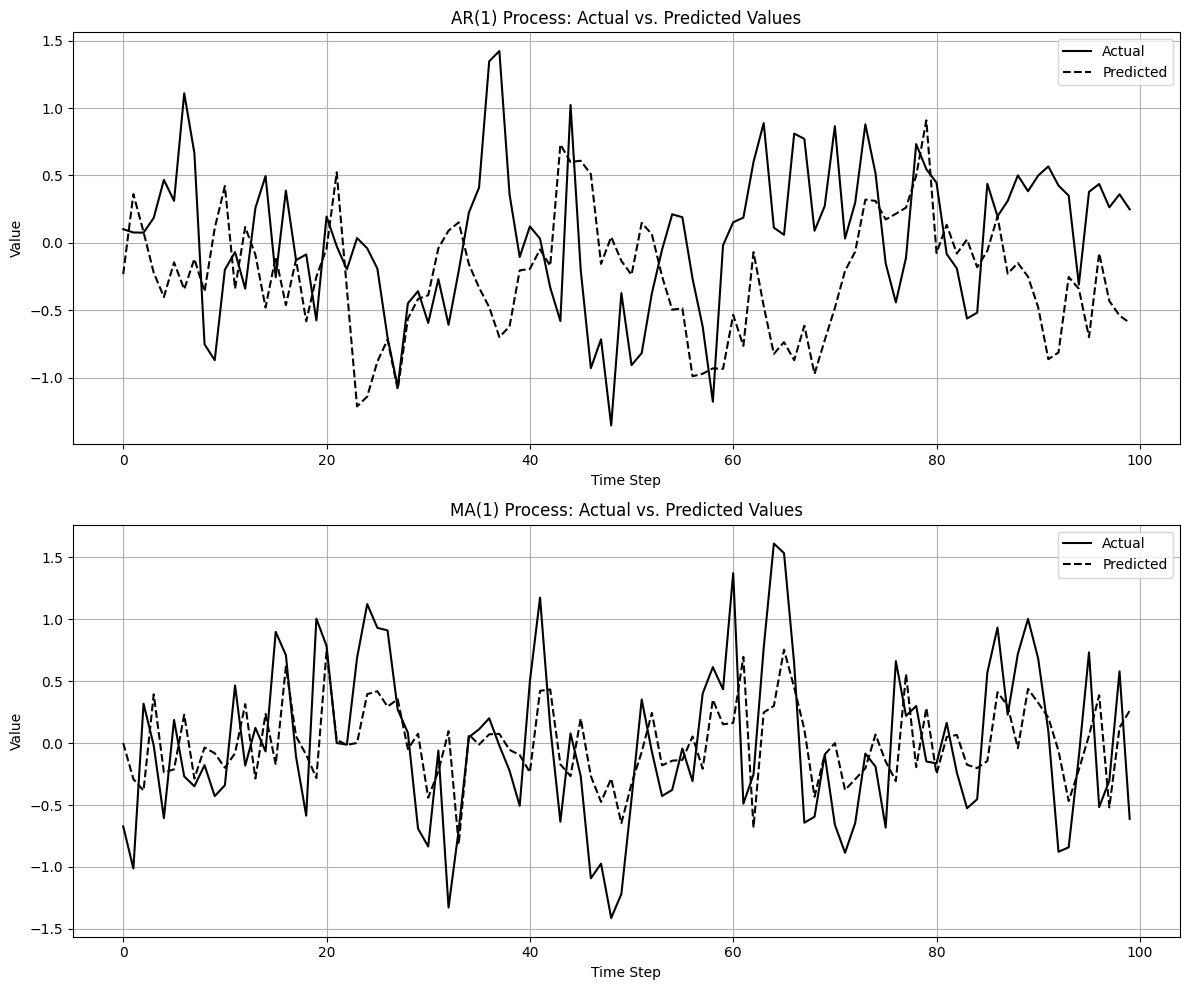

In [ ]:
"""
Simulate and fit two hypothetical time series (N=100) with AR(1) and MA(1) models. Plot actual vs. predicted values
"""
from statsmodels.tsa.arima_process import arma_generate_sample

# Define the AR coefficients for an AR(1) process with a coefficient of 0.6
ar_coeffs_ar1 = [1, -0.6]
ma_coeffs_ar1 = [1]
ar_data = arma_generate_sample(ar=ar_coeffs_ar1, ma=ma_coeffs_ar1, nsample=100, scale=0.5, burnin=100)

# Define the MA coefficients for an MA(1) process with a coefficient of 0.6
ma_coeffs_ma1 = [1, 0.6]
ar_coeffs_ma1 = [1]

# Simulate values
ar_data = arma_generate_sample(ar=ar_coeffs_ar1, ma=ma_coeffs_ar1, nsample=100, scale=0.5, burnin=100)
ma_data = arma_generate_sample(ar=ar_coeffs_ma1, ma=ma_coeffs_ma1, nsample=100, scale=0.5, burnin=100)


from statsmodels.tsa.statespace.sarimax import SARIMAX

# Instantiate and fit the AR(1) model
ar_model = SARIMAX(ar_data, order=(1, 0, 0), trend='n')
ar_fitted_values = ar_results.fittedvalues
# Instantiate and fit the MA(1) model
ma_model = SARIMAX(ma_data, order=(0, 0, 1), trend='n')
ma_results = ma_model.fit(disp=False)
ma_fitted_values = ma_results.fittedvalues

# Plot actual vs. predicted values
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Plot AR(1) Actual vs. Fitted
axes[0].plot(ar_data, label='Actual', color='black')
axes[0].plot(ar_fitted_values, label='Predicted', color='black', linestyle='--')
axes[0].set_title('AR(1) Process: Actual vs. Predicted Values')
axes[0].set_xlabel('Time Step')
axes[0].set_ylabel('Value')
axes[0].legend()
axes[0].grid(True)

# Plot MA(1) Actual vs. Fitted
axes[1].plot(ma_data, label='Actual', color='black')
axes[1].plot(ma_fitted_values, label='Predicted', color='black', linestyle='--')
axes[1].set_title('MA(1) Process: Actual vs. Predicted Values')
axes[1].set_xlabel('Time Step')
axes[1].set_ylabel('Value')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


In [ ]:


"""
Auto ARIMA

The pm.auto_arima function in the pmdarima library is used for automatically selecting the best ARIMA model for a given time series
dataset. It performs a grid search over possible combinations of AR, MA, and differencing terms, and selects the model with the
lowest information criterion (such as AIC or BIC) or a specified evaluation metric.
"""
!pip install pmdarima
import pmdarima as pm
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

# Define time series. Load either the Nikkiestutorial data, or the Ajahn Brahm data
series=pd.read_csv('Nikkie.csv')
series=series['Analytic']
plt.plot(series)

series=pd.read_csv('Brahm.csv')
series=series['Authentic']
plt.plot(series)



# Split the data into training and testing sets
train_size = int(len(series) * 0.8)
train_data = series[:train_size]
test_data = series[train_size:]

"""
Fit the best ARIMA model automatically

The m parameter = the number of observations per seasonal cycle, or the number of time steps in each season
For example, if the data has a yearly seasonality, the seasonal period would be 12 for monthly data.
m must be known apriori. Typically, m will correspond to some recurrent periodicity such as 7 (daily), 12 (monthly), 52 (weekly)
"""
model = pm.auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # Use the ADF test to find the optimal differencing term (d)
                      max_p=3, max_q=3,  # Set the maximum values of p and q
                      m=4,              # Set the seasonal period (for seasonal ARIMA models). If unknown (e.g. not obvious annual or monthly data, consider a loop to find best m (see below))
                      d=None,           # Let the model determine the optimal differencing term (d) by performing a statistical test (such as the Augmented Dickey-Fuller test) to determine if differencing is required. If the data is already stationary, it will skip differencing. If differencing is required, the function will select the optimal value for d based on the test results.
                      seasonal=False,   # Set to True for seasonal ARIMA models. If seasonal is True and m=1, seasonal will be set to False.
                      start_P=0,        # Set the starting values of P and Q for seasonal ARIMA models
                      D=None,              # Set the differencing term for seasonal ARIMA models
                      trace=True,       # Print diagnostic information during model selection
                      error_action='ignore',  # Ignore errors that occur during model fitting
                      suppress_warnings=True,  # Suppress warnings that occur during model fitting
                      stepwise=True)    # Use a stepwise algorithm to search for the best model

# Print the summary of the selected model
print(model.summary())

#Predict on train data
predictions = model.predict_in_sample()
#Predict on test data
forecasts= model.predict(n_periods=len(test_data))

"""
To fit a model manually and get predictions, forecasts. Change the order=(...) to your desired model
"""
model=sm.tsa.SARIMAX(train_data,order=(1,0,2),seasonal_order = (0,0,0,0), trend='c').fit()   #seasonal_order = (P, D, Q, m)
model.summary()

model=sm.tsa.SARIMAX(train_data,order=(2,0,2),seasonal_order = (0,0,0,0), trend=None).fit()  #without intercept
model.summary()

#Predict on train data
predictions=model.predict(start=0, end=len(train_data)-1)
#Predict on test data
forecasts= model.predict(start=len(train_data), end=len(series)-1)

#Evaluate model
train_rmse = np.sqrt(np.mean((train_data - predictions) ** 2))
test_rmse = np.sqrt(np.mean((test_data - forecasts) ** 2))

train_mape = mean_absolute_percentage_error(train_data,predictions)
test_mape = mean_absolute_percentage_error(test_data, forecasts)

train_r2 = r2_score(train_data, predictions)
test_r2 =  r2_score(test_data, forecasts)

#Print predictive accuracy metrics
print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)
print("Train MAPE:", train_mape)
print("Test MAPE:", test_mape)
print("Train R2:", train_r2)
print("Test R2:", test_r2)


"""
PLOT predictions/forecasts vs. observed
"""
#Create axes
x1 = np.arange(0, len(train_data))
x2 = np.arange(len(train_data), len(train_data)+len(test_data))
x3= np.arange(0, len(train_data)+len(test_data))


plt.plot(x3,series, label="actual", color='dodgerblue')
plt.plot(x1,predictions, label="train_predict",color='orange')
plt.plot(x2,forecasts, label="test_predict",color='red')
plt.legend()
plt.vlines(x=int(len(train_data)), color='r',linestyles='dashed', ymin = min(series), ymax = max(series))
plt.title('Actual vs. predicted values')
plt.show()




